In [1]:
# DB 
import psycopg2
from django.conf import settings
from django.db.models import Case, IntegerField, Value

# Helpers
import numpy as np
from collections import Counter, defaultdict
import pickle
import rpy2

# Learning
from sklearn.cluster import AgglomerativeClustering

# Evaluation
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.decomposition import PCA
from sklearn import manifold

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext rpy2.ipython

In [2]:
%%R
library(factoextra)
library(proxy)
library(permute)
library(lattice)
library(vegan)
library(tidyverse)

R[write to console]: Loading required package: ggplot2

R[write to console]: Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.had.co.nz/

R[write to console]: Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

R[write to console]: 
Attaching package: ‘proxy’


R[write to console]: The following objects are masked from ‘package:stats’:

    as.dist, dist


R[write to console]: The following object is masked from ‘package:base’:

    as.matrix


R[write to console]: This is vegan 2.5-6

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

In [3]:
folder = "data/tese"

In [4]:
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                                  password = settings.DATABASES["default"]["PASSWORD"],
                                  host = settings.DATABASES["default"]["HOST"],
                                  port = settings.DATABASES["default"]["PORT"],
                                  database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

In [5]:
def get_exp(exp_id):
    # Get experiments results
    query = """select X, q_matrix, q_matrix_hat, concepts, method, attempts_train
    from EDM2020_2020_06_05 where experiment_id = %s """

    query = cursor.mogrify(query, (exp_id,))
    cursor.execute(query)
    response = cursor.fetchall()
    return response

def transform_fdtf_data(exps):
    data = {}
    for idx, row in enumerate(exps):
        (X, q_matrix, q_matrix_hat, concepts, method, attempts) = row
        X = np.asarray(X)
        q_matrix = np.asarray(q_matrix)
        q_matrix_hat = np.asarray(q_matrix_hat)
        data[idx] = {}
        data[idx]['method'] = method
        data[idx]['concepts'] = concepts
        data[idx]['attempts'] = attempts
        
        # Fix original Q-Matrix to have the same number of questions
        attempts_per_question = X.sum(axis=0).sum(axis=1)
        del_questions = [idx for idx,value in enumerate(attempts_per_question) if value < 3]
        print(del_questions)
        q_matrix = np.delete(q_matrix, del_questions, axis=1)
        print(q_matrix.shape)
        print(q_matrix_hat.shape)

        data[idx]['q_matrix'] = np.asarray(q_matrix)
        data[idx]['q_matrix_hat'] = np.asarray(q_matrix_hat)
        
        np.savetxt("data/tese/q_matrix_fdtf_%d.csv" % attempts, q_matrix_hat, delimiter=",")
        np.savetxt("data/tese/q_matrix_fdtf_%d_original.csv" % attempts, q_matrix, delimiter=",")

        # Calculate similarities among questions in Q-Matrix and estimated Q-Matrix
        data[idx]['question_similarity'] = cosine_similarity(q_matrix.T)
        data[idx]['question_distance'] = cosine_distances(q_matrix.T)
        data[idx]['question_hat_similarity'] = cosine_similarity(q_matrix_hat.T)
        data[idx]['question_hat_distance'] = cosine_distances(q_matrix_hat.T)
        error = data[idx]['question_similarity'] - data[idx]['question_hat_similarity']

    return data.values()

In [17]:
exp_id = 171
response = get_exp(exp_id)
data = list(transform_fdtf_data(response))[0]
q_matrix  = data['q_matrix'].T
q_matrix_hat = data['q_matrix_hat'].T

[]
(14, 47)
(3, 47)


In [18]:
%%R -i q_matrix -i q_matrix_hat -o anosim_data 
# data <- read.csv('q_matrix_automated.csv', header=FALSE)
# data_original <-read.csv('q_matrix_original.csv', header=FALSE)

d <- dist(q_matrix_hat, method = "euclidean")
d_original <- dist(q_matrix, method = "jaccard")
res.hc <- hclust(d=d, method = "ward.D2")

stats <- c()
stats$k <- c()
stats$R <- c()
stats$signif <- c()

for (k in c(2:15))
{
  print(k)
  clusterCut <- cutree(res.hc, k)
  a <- anosim(d_original, clusterCut, permutations = 10000)
  stats$k <- c(stats$k, k)
  stats$R <- c(stats$R, a$statistic)
  stats$signif <- c(stats$signif, a$signif)
}

anosim_data <- data.frame(stats)

[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15


In [19]:
anosim_data

,k,R,signif
1,2,-0.035570,0.784922
2,3,-0.049844,0.814919
3,4,-0.013428,0.577942
4,5,0.004138,0.446955
5,6,-0.019112,0.627637
6,7,-0.010001,0.543846
7,8,-0.027406,0.672633
8,9,-0.023009,0.627437
9,10,0.009040,0.413359
10,11,0.007312,0.428857


In [20]:
anosim_data[anosim_data['signif'] < 0.1]

,k,R,signif


In [11]:
exp_id = 172
response = get_exp(exp_id)
data = list(transform_fdtf_data(response))[0]
q_matrix  = data['q_matrix'].T
q_matrix_hat = data['q_matrix_hat'].T

[]
(14, 48)
(6, 48)


In [12]:
%%R -i q_matrix -i q_matrix_hat -o anosim_data 
# data <- read.csv('q_matrix_automated.csv', header=FALSE)
# data_original <-read.csv('q_matrix_original.csv', header=FALSE)

d <- dist(q_matrix_hat, method = "euclidean")
d_original <- dist(q_matrix, method = "jaccard")
res.hc <- hclust(d=d, method = "ward.D2")

stats <- c()
stats$k <- c()
stats$R <- c()
stats$signif <- c()

for (k in c(2:15))
{
  print(k)
  clusterCut <- cutree(res.hc, k)
  a <- anosim(d_original, clusterCut, permutations = 10000)
  stats$k <- c(stats$k, k)
  stats$R <- c(stats$R, a$statistic)
  stats$signif <- c(stats$signif, a$signif)
}

anosim_data <- data.frame(stats)

[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15


In [13]:
anosim_data[anosim_data['signif'] < 0.1]

,k,R,signif


In [14]:
exp_id = 173
response = get_exp(exp_id)
data = list(transform_fdtf_data(response))[0]

[]
(14, 48)
(12, 48)


In [15]:
%%R -i q_matrix -i q_matrix_hat -o anosim_data 
# data <- read.csv('q_matrix_automated.csv', header=FALSE)
# data_original <-read.csv('q_matrix_original.csv', header=FALSE)

d <- dist(q_matrix_hat, method = "euclidean")
d_original <- dist(q_matrix, method = "jaccard")
res.hc <- hclust(d=d, method = "ward.D2")

stats <- c()
stats$k <- c()
stats$R <- c()
stats$signif <- c()

for (k in c(2:15))
{
  print(k)
  clusterCut <- cutree(res.hc, k)
  a <- anosim(d_original, clusterCut, permutations = 10000)
  stats$k <- c(stats$k, k)
  stats$R <- c(stats$R, a$statistic)
  stats$signif <- c(stats$signif, a$signif)
}

anosim_data <- data.frame(stats)

[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15


In [16]:
anosim_data[anosim_data['signif'] < 0.1]

,k,R,signif


In [409]:
model = AgglomerativeClustering(n_clusters=19, 
                                affinity='cosine',
                                linkage='complete').fit(data['q_matrix_hat'].T)
hat_clusters = model.labels_
hat_clusters

array([16,  9,  3, 14,  1,  1,  5, 18,  2,  5, 14, 13,  4,  1, 14, 11,  4,
        9,  6, 15,  0,  1,  0, 12, 14,  1, 11,  9, 10, 13, 13,  0,  7,  0,
        3,  6,  2, 16, 17,  8, 10, 10,  8, 15,  7, 15,  5, 12])

In [410]:
unique_clusters = set(hat_clusters)
questions_idx = np.asarray(dataset['questions_idx'])

Redoing attempts statistics

In [415]:
# Filter used problems and solutions
last_id = 132
problems = Problem.objects.filter(id__lte=last_id)
solutions = Solution.objects.filter(problem__in=problems, ignore=False).values_list('problem', flat=True)
problems = solutions.order_by('problem').values_list(
    'problem', flat=True).distinct('problem')
print("Total number of questions: %d" % problems.count())

# Get all students
user_blacklist = UserProfile.objects.filter(professor__user__username='sem_professor')

attempts = UserLog.objects.exclude(outcome='S').filter(
    timestamp__lt=OuterRef('timestamp'), user__id=OuterRef('user__id')).annotate(
    attempt=Count('*')).values('attempt')

# Remove group by values
attempts.query.set_group_by()

# Get users
users = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').exclude(
    user__userprofile__in=user_blacklist).annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0.1)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list(
    "user__id", "problem_id", "attempt", "score"#"outcome", "timestamp"
).order_by("timestamp").filter(attempt=1).values_list('user_id', flat=True)

cluster_data = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).order_by("timestamp").filter(user__in=users)

attempts_total = cluster_data.count()
print("Total number of attempts: %d" % attempts_total)

Total number of questions: 48
Total number of attempts: 3632


In [412]:
# Get voted concepts per solution
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution').annotate(count=Count('user', distinct=True))
sol_id, eval_count = zip(*list(count))

# Get voted concepts per problem
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution__problem').annotate(count=Count('user', distinct=True))
sol_id, eval_count = zip(*list(count))

# Count concept agreement per problem
count_per_problem = dict(concepts.values_list('solution__problem').annotate(
    count=Count('user', distinct=True)))

MIN_THRESHOLD = 0.5
agreed_concepts = defaultdict(list)
agreed_concepts_len = {}

# Filter out the concepts that didn't have agreement (50% of evaluators voted for it)
for problem in problems:
    max_votes = count_per_problem[problem]
    concepts_per_problem = dict(concepts.filter(solution__problem=problem).values_list('concept').annotate(
        count=Count("concept")))
    for concept, value in concepts_per_problem.items():
        if value >= (max_votes * MIN_THRESHOLD):
            agreed_concepts[problem].append(concept)
    agreed_concepts_len[problem] = len(agreed_concepts[problem])

In [457]:
points = []

success_per_question_cluster = defaultdict(dict)
for i, cluster in enumerate(unique_clusters):
    q_idx = questions_idx[np.where(hat_clusters == cluster)]

    # Filter cluster problems
    problems = Problem.objects.filter(id__in=q_idx)
    print("Total number of questions: %d" % problems.count())
    
    # Get concepts
    concept_c = defaultdict(int)
    for problem in problems:
        print(agreed_concepts[problem.id])
        conc = agreed_concepts[problem.id]
        for c in conc:
            concept_c[c] += 1
    cs, votes = zip(*list(concept_c.items()))
    best_c = np.asarray(cs)[np.where(np.asarray(votes) == problems.count())]
    print(concept_c)

    # Get attempts
    attempts = cluster_data.filter(problem__in=problems).values_list(
        "user__id", "problem_id", "attempt", "score")
    
    # Get students
    user = set(cluster_data.filter(problem__in=problems).values_list('user__id', flat=True))
    
    attempts_count = attempts.count()
#     users_total = users.count()
    success_attempts = attempts.filter(score=1)
    fail_attempts = attempts.filter(score=0)

    print("Total of %d attempts" % attempts_count)
    print("Total percentage of attempts: %.2f" % (attempts_count/attempts_total*100))
#     print("Total of %d students" % users_total)
#     print("Average of attempt per student: %.2f" % (attempts_total/users_total))
    success_perc = success_attempts.count()/attempts_count
    print("Success attempts: %d (%.2f%%)" % (success_attempts.count(), 100*success_perc))
    print("Failed attempts: %d (%.2f%%)" % (fail_attempts.count(), 100*fail_attempts.count()/attempts_count))
#     print()
    
    success_per_student = defaultdict(int)
    fail_per_student = defaultdict(int)
    success_per_question = defaultdict(int)
    fail_per_question = defaultdict(int)

    for row in success_attempts:
        s_idx, q_idx, a_idx, outcome = row
        success_per_student[s_idx] += 1
        success_per_question[q_idx] += 1


    for row in fail_attempts:
        s_idx, q_idx, a_idx, outcome = row
        fail_per_student[s_idx] += 1
        fail_per_question[q_idx] += 1
        
    success_per_question_cluster[i] = success_per_question

#     min_student_success_attempt = min(success_per_student.values())
#     max_student_success_attempt = max(success_per_student.values())
#     avg_student_success_attempt = np.mean(list(success_per_student.values()))
#     min_student_fail_attempt = min(fail_per_student.values())
#     max_student_fail_attempt = max(fail_per_student.values())
#     avg_student_fail_attempt = np.mean(list(fail_per_student.values()))

    min_question_success_attempt = min(success_per_question.values())
    max_question_success_attempt = max(success_per_question.values())
    avg_question_success_attempt = np.mean(list(success_per_question.values()))
    median_question_success_attempt = np.median(list(success_per_question.values()))
    min_question_fail_attempt = min(fail_per_question.values())
    max_question_fail_attempt = max(fail_per_question.values())
    avg_question_fail_attempt = np.mean(list(fail_per_question.values()))
    median_question_fail_attempt = np.median(list(fail_per_question.values()))

#     print("Min student success attempt: %d" % min_student_success_attempt)
#     print("Max student success attempt: %d" % max_student_success_attempt)
#     print("Avg student success attempt: %.2f" % avg_student_success_attempt)

#     print("Min student fail attempt: %d" % min_student_fail_attempt)
#     print("Max student fail attempt: %d" % max_student_fail_attempt)
#     print("Avg student fail attempt: %.2f" % avg_student_fail_attempt)

    print("Min question success attempt: %d" % min_question_success_attempt)
    print("Max question success attempt: %d" % max_question_success_attempt)
    print("Avg question success attempt: %.2f" % avg_question_success_attempt)
    print("Median question success attempt: %.2f" % median_question_success_attempt)

    print("Min question fail attempt: %d" % min_question_fail_attempt)
    print("Max question fail attempt: %d" % max_question_fail_attempt)
    print("Avg question fail attempt: %.2f" % avg_question_fail_attempt)
    print("Median question fail attempt: %.2f" % median_question_fail_attempt)
    print()
    
    points.append([attempts_count, success_perc, len(user), best_c.tolist()])

Total number of questions: 4
[6, 11, 14, 5]
[11, 7, 12]
[8, 13, 12, 5]
[12]
defaultdict(<class 'int'>, {6: 1, 11: 2, 14: 1, 5: 2, 7: 1, 12: 3, 8: 1, 13: 1})
Total of 398 attempts
Total percentage of attempts: 10.96
Success attempts: 30 (7.54%)
Failed attempts: 368 (92.46%)
Min question success attempt: 4
Max question success attempt: 10
Avg question success attempt: 7.50
Median question success attempt: 8.00
Min question fail attempt: 21
Max question fail attempt: 252
Avg question fail attempt: 92.00
Median question fail attempt: 47.50

Total number of questions: 5
[11, 12, 5]
[11, 5, 12]
[6, 11, 14, 7]
[11, 7, 12]
[6, 11, 7, 12]
defaultdict(<class 'int'>, {11: 5, 12: 4, 5: 2, 6: 2, 14: 1, 7: 3})
Total of 252 attempts
Total percentage of attempts: 6.94
Success attempts: 68 (26.98%)
Failed attempts: 184 (73.02%)
Min question success attempt: 7
Max question success attempt: 22
Avg question success attempt: 13.60
Median question success attempt: 12.00
Min question fail attempt: 18
Max que

[11, 8, 12]
[7, 10, 12]
defaultdict(<class 'int'>, {11: 1, 8: 1, 12: 2, 7: 1, 10: 1})
Total of 173 attempts
Total percentage of attempts: 4.76
Success attempts: 38 (21.97%)
Failed attempts: 135 (78.03%)
Min question success attempt: 13
Max question success attempt: 25
Avg question success attempt: 19.00
Median question success attempt: 19.00
Min question fail attempt: 35
Max question fail attempt: 100
Avg question fail attempt: 67.50
Median question fail attempt: 67.50

Total number of questions: 1
[5, 3, 7]
defaultdict(<class 'int'>, {5: 1, 3: 1, 7: 1})
Total of 304 attempts
Total percentage of attempts: 8.37
Success attempts: 88 (28.95%)
Failed attempts: 216 (71.05%)
Min question success attempt: 88
Max question success attempt: 88
Avg question success attempt: 88.00
Median question success attempt: 88.00
Min question fail attempt: 216
Max question fail attempt: 216
Avg question fail attempt: 216.00
Median question fail attempt: 216.00

Total number of questions: 1
[11, 8, 12, 5]
def

In [458]:
points

[[398, 0.07537688442211055, 26, []],
 [252, 0.2698412698412698, 56, [11]],
 [259, 0.17374517374517376, 62, [11, 12]],
 [96, 0.125, 15, [12]],
 [219, 0.1232876712328767, 34, [11]],
 [117, 0.4017094017094017, 36, [14]],
 [178, 0.10112359550561797, 24, []],
 [89, 0.29213483146067415, 27, [14]],
 [301, 0.21926910299003322, 72, [12]],
 [206, 0.18446601941747573, 39, [11, 14]],
 [159, 0.2138364779874214, 33, []],
 [177, 0.1016949152542373, 25, []],
 [74, 0.22972972972972974, 20, []],
 [156, 0.33974358974358976, 41, [14]],
 [269, 0.30111524163568776, 65, []],
 [82, 0.573170731707317, 35, [14]],
 [173, 0.21965317919075145, 38, [12]],
 [304, 0.2894736842105263, 71, [5, 3, 7]],
 [123, 0.08943089430894309, 14, [11, 8, 12, 5]]]

In [487]:
label_lookup[(11,)]

'Conditional'

In [ ]:
import matplotlib.lines as mlines
# import matplotlib.pyplot as plt

blue_star = mlines.Line2D([], [], color='blue', marker='*', linestyle='None',
                          markersize=10, label='Blue stars')
red_square = mlines.Line2D([], [], color='red', marker='s', linestyle='None',
                          markersize=10, label='Red squares')
purple_triangle = mlines.Line2D([], [], color='purple', marker='^', linestyle='None',
                          markersize=10, label='Purple triangles')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

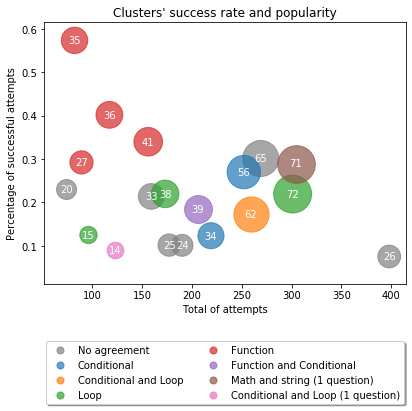

In [565]:
label_lookup = {(11,): "Conditional",
                (12,): "Loop",
                (11, 12): "Conditional and Loop",
                (0,): "No agreement",
                (14,): "Function",
                (11, 14): "Function and Conditional",
                (5,3,7): "Math and string (1 question)",
                ((11, 8, 12, 5)): "Conditional and Loop (1 question)"}

labels = [item[3] for item in points]
unique_labels = []

for l in labels:
    if l not in unique_labels:
        unique_labels.append(l)

x = np.asarray([item[0] for item in points])
y = np.asarray([item[1] for item in points])
s = np.asarray([item[2] for item in points])

fig, ax = plt.subplots(figsize=(6,6))        
for l in unique_labels:
    idx = []
    for i, item in enumerate(points):
        if item[3] == l:
            idx.append(i)
    try:
        label = label_lookup[tuple(l,)]
        ax.scatter(x[idx], y[idx], s[idx]*20, alpha=0.7, label=label)
    except KeyError:
        if not l:
            label = label_lookup[(0,)]
            # Hack to pretty print
            x[np.where(x == 178)] = 190
            ax.scatter(x[idx], y[idx], s[idx]*20, alpha=0.7, label=label, color='gray')
            
for idx in range(len(x)):
    text = ax.text(x[idx], y[idx], s[idx], ha="center", va="center", color="w")

ax.set_title("Clusters' success rate and popularity")
ax.set_xlabel("Total of attempts")
ax.set_ylabel("Percentage of successful attempts")
# Put a legend below current axis
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
# lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle._sizes = [50]
    
plt.tight_layout()
plt.savefig('edm2020/cluster_success.eps', format='eps')
plt.savefig('edm2020/cluster_success.png', format='png')
plt.show()